In [1]:
import numpy as np

In [2]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Activation, Dropout, Dense

Using TensorFlow backend.


In [ ]:
from sklearn.utils import class_weight

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from collections import Counter
from tqdm import tqdm

In [5]:
from spawn import expand_data_set

In [6]:
from loaddataset import *

In [7]:
def buildmodel(modeltype,T,K,activation=None,dropout=None,hlayer1=None,hlayer2=None):
    model = Sequential()
    adam = Adam()
    if modeltype == 'MLP':
        # 1st hidden layer
        model.add(Dense(units=hlayer1, input_dim=T))
        model.add(Activation(activation))
        model.add(Dropout(dropout))

        # 2nd hidden layer
        if hlayer2:
            model.add(Dense(units=hlayer2))
            model.add(Activation(activation))
            model.add(Dropout(dropout))

        # output
        model.add(Dense(units=K,activation='softmax'))
        
    elif modeltype == 'LSTM':
        # 1st hidden layer
        model.add(LSTM(units=hlayer1,input_shape=(T,1), 
                       return_sequences=False,
                       dropout=dropout,
                       recurrent_dropout=dropout))

        # 2nd hidden layer
        if hlayer2:
            model.add(Dense(units=hlayer2, activation=activation))

        # output
        model.add(Dense(units=K, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['categorical_accuracy'])
    return model

In [8]:
def train(dataset, n_runs, modeltyp, activation, dropout, hlayer1, hlayer2, batchsize, epochs):
    results = []
    
    Xtrain = dataset.data[:,:,np.newaxis] if modeltyp == 'LSTM' else dataset.data
    Xtest = dataset.test_data[:,:,np.newaxis] if modeltyp == 'LSTM' else dataset.test_data
    Ytrain = to_categorical(dataset.labels, num_classes=dataset.K)
    Ytest = to_categorical(dataset.test_labels, num_classes=dataset.K)

    class_weights = class_weight.compute_class_weight('balanced', np.unique(dataset.labels), dataset.labels)

    for r in tqdm(range(n_runs)):
        model = buildmodel(modeltyp,dataset.T,dataset.K,activation,dropout,hlayer1,hlayer2)
        history = model.fit(Xtrain, Ytrain, epochs=epochs, validation_data=(Xtest, Ytest), shuffle=True, verbose=0, batch_size=batchsize, class_weight=class_weights)
        results.append([history.history['categorical_accuracy'],history.history['val_categorical_accuracy']])
    return np.array(results)

In [9]:
datasetname = 'Wine'
EXP = loaddataset(name=datasetname, train_suffix='_EXP10_TRAIN', test_suffix='_TEST')
ALT = loaddataset(name=datasetname, train_suffix='_ALT70_TRAIN', test_suffix='_ALT70_TEST')
ORG = loaddataset(name=datasetname)
class_dist = EXP.class_dist

Dataset Wine has been loaded with class distribution of: Counter({0.0: 284, 1.0: 233}), test:54
Dataset Wine has been loaded with class distribution of: Counter({1.0: 39, 0.0: 38}), test:34
Dataset Wine has been loaded with class distribution of: Counter({0.0: 30, 1.0: 27}), test:54


In [10]:
# MERGE EXTENDED WITH ORIGINAL DATA
EXP = EXP._replace(data=np.concatenate([EXP.data,ORG.data]))
EXP = EXP._replace(labels=np.concatenate([EXP.labels,ORG.labels]))
EXP = EXP._replace(class_dist=Counter(EXP.labels))

In [11]:
datasets = {'EXP':EXP, 'ORG':ORG, 'ALT':ALT}
for k, i in datasets.items():
    print(k, '{}/{}'.format(i.N, len(i.test_data)))

EXP 517/54
ORG 57/54
ALT 77/34


In [12]:
results = {}
for suffix, dataset in datasets.items():
    results[suffix] = train(dataset, 10, 'MLP', 'relu', 0.1, 50, 30, 20, 150)
    print(suffix, np.mean(results[suffix][:,1,:].mean(0)[-10:]))

  0%|          | 0/1 [00:00<?, ?it/s]

EXP 0.499999997792


  0%|          | 0/1 [00:00<?, ?it/s]

ORG 0.516666664569


100%|██████████| 1/1 [00:02<00:00,  2.61s/it]

ALT 0.632352942053


EXP error rate 0.500000002208
ORG error rate 0.483333335431
ALT error rate 0.367647057947


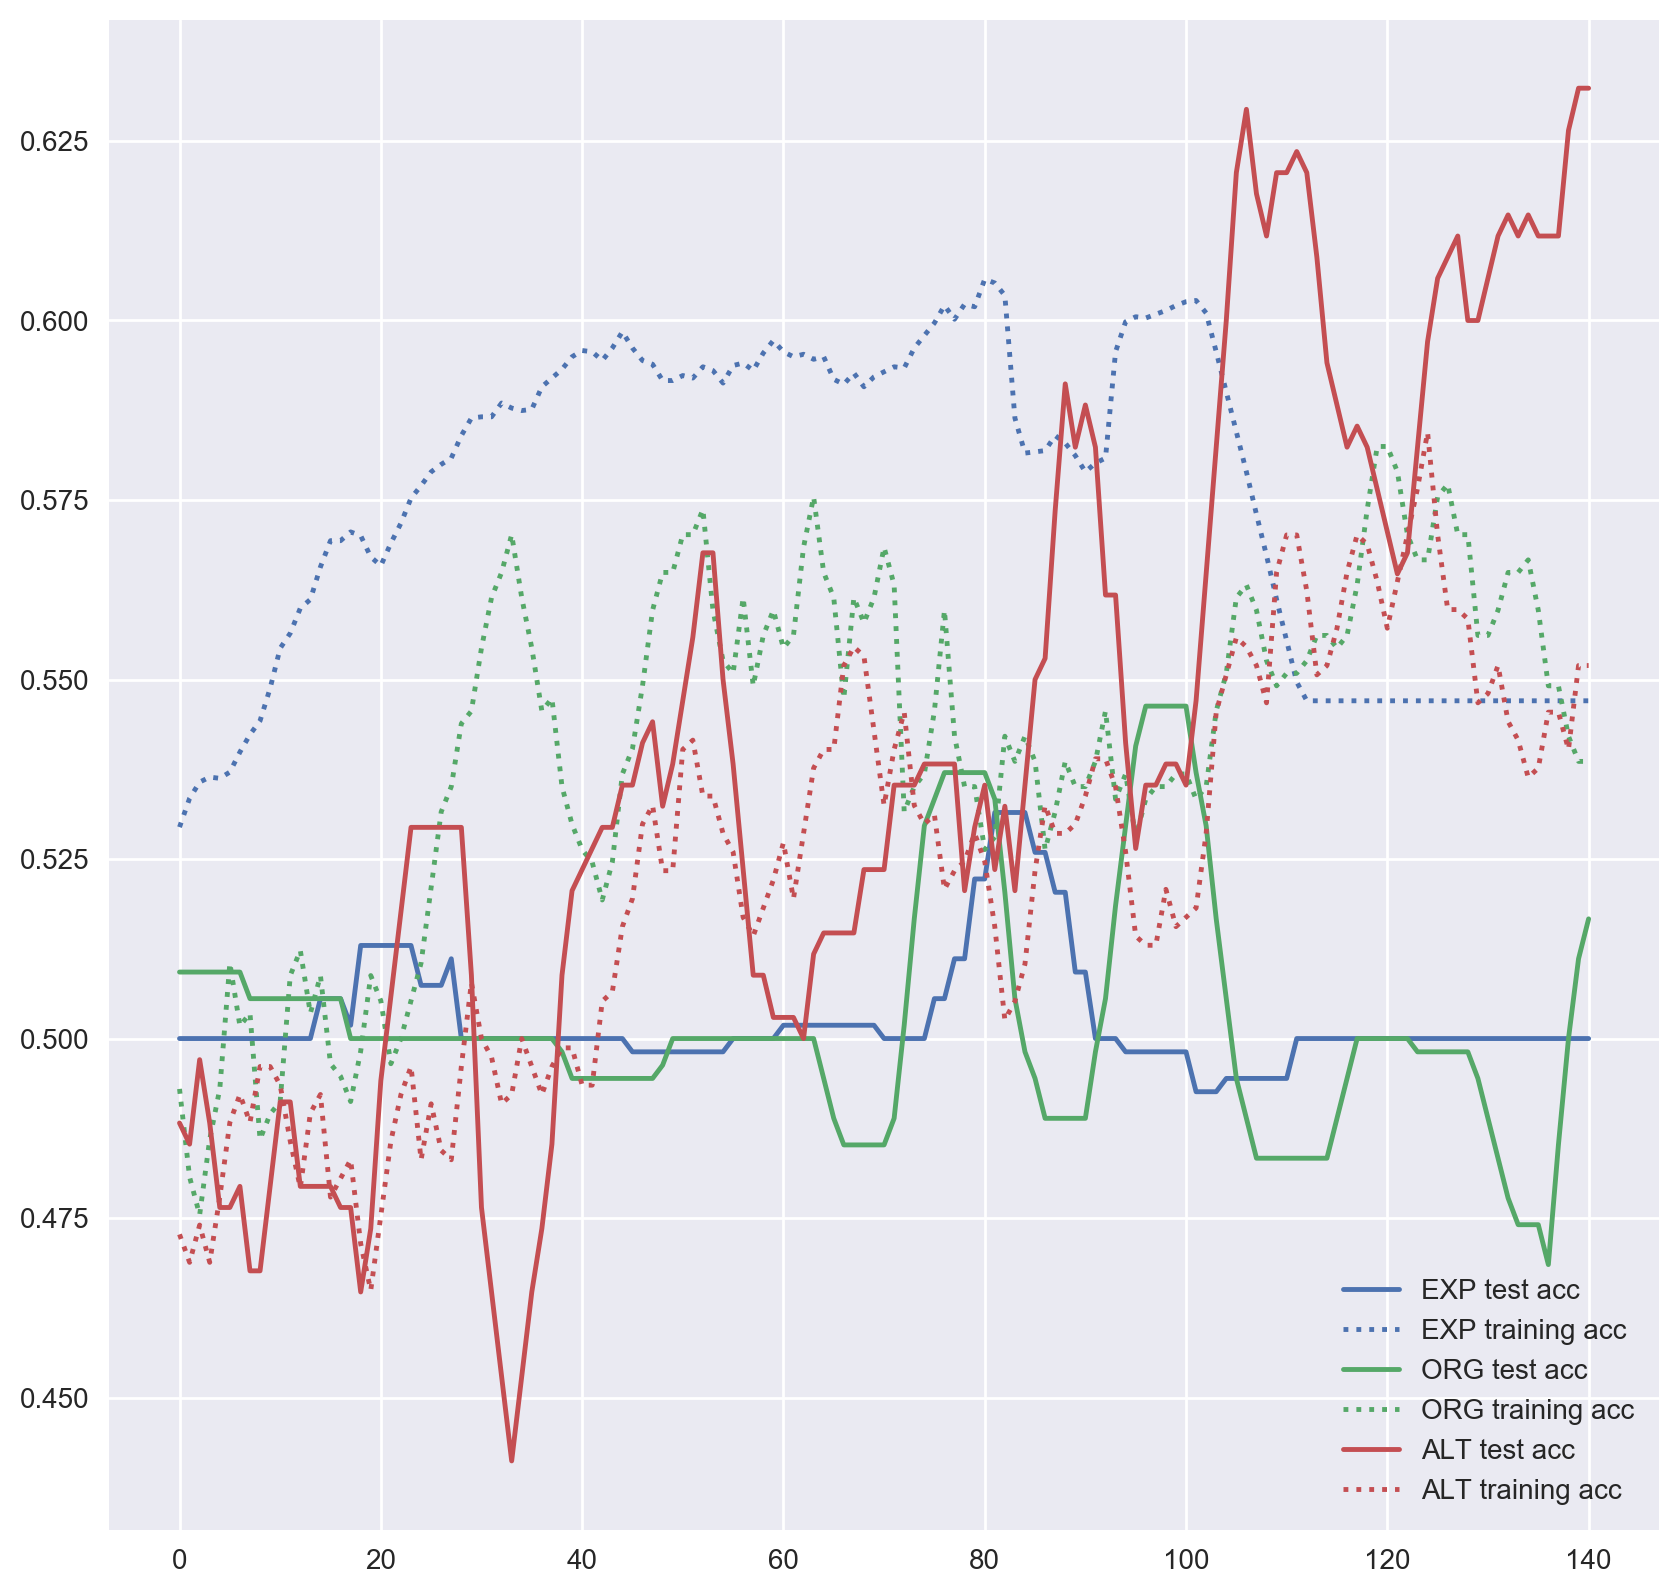

In [13]:
smooth = lambda d: np.convolve(np.array(d), np.ones((10,))/10, mode='valid')
plt.figure(figsize=(10,10),dpi=200)
current_palette = sns.color_palette()
color_i = 0
for suffix, result in results.items():
    plt.plot(smooth(result[:,1,:].mean(0)), linestyle ='-', color=current_palette[color_i], label=suffix + ' test acc')
    plt.plot(smooth(result[:,0,:].mean(0)), linestyle=':', color=current_palette[color_i], label=suffix + ' training acc')
    print(suffix, 'error rate', 1-np.mean(result[:,1,:].mean(0)[-10:]))
    plt.legend(loc=4)
    color_i +=1
plt.show()